In [1]:
import torch

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Will look for the available gpu otherwise select cpu processing
device

device(type='cpu')

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor   # [0,255] -> [0.0,1.0]


train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37095899.17it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1251001.17it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8092955.06it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5741569.85it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [7]:
print(train_data.targets.size())

torch.Size([60000])


In [8]:
test_data.data.size()

torch.Size([10000, 28, 28])

In [9]:
test_data.targets.size()

torch.Size([10000])

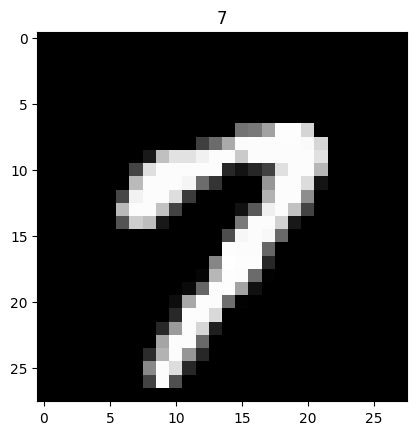

In [10]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[15], cmap='gray')
plt.title('%i' % train_data.targets[15])
plt.show()

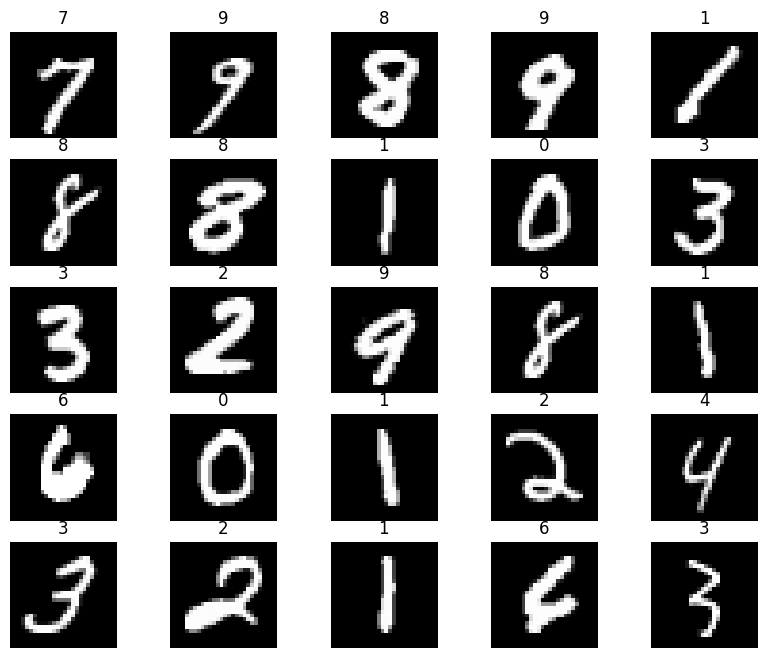

In [11]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    #convert 3D, into 2D
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [12]:
img.squeeze().size()

torch.Size([28, 28])

In [13]:
img.size()

torch.Size([1, 28, 28])

In [14]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),   #num_workers is actually number of threads to process that data

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7e0434b334f0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7e0434b332e0>}

In [15]:
import torch.nn as nn       #Importing Neural Network
class CNN(nn.Module): #Defining CNN class and inheriting it from Neural Network Module Class.
    def __init__(self):
        super(CNN, self).__init__()  #Calling Parent Constructor
        self.conv1 = nn.Sequential(               #First Layer
            nn.Conv2d(
                in_channels=1,       #in_channel is 1, bcz its gray image, if its coloured image it will be 3(Red, Green, and Blue)
                out_channels=16,            #out_channel , outputs produced by the input channel
                kernel_size=5,              #Selection of small matrix from the image tensor
                stride=1,                   #number of pixel to be passed in the Cnn layer
                padding=2,                  #Additional size added to the kernal matrix
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(             #Hidden Layers
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

In [16]:
cnn = CNN()   #calling CNN constructor
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [17]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [18]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [19]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):

    cnn.train()  #Training function

    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]      # maybe multiple ouput generated by model picking the first one
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

train(num_epochs, cnn, loaders) #calling function train

Epoch [1/10], Step [100/600], Loss: 0.1427
Epoch [1/10], Step [200/600], Loss: 0.0256
Epoch [1/10], Step [300/600], Loss: 0.0551
Epoch [1/10], Step [400/600], Loss: 0.0940
Epoch [1/10], Step [500/600], Loss: 0.1029
Epoch [1/10], Step [600/600], Loss: 0.0808
Epoch [2/10], Step [100/600], Loss: 0.0823
Epoch [2/10], Step [200/600], Loss: 0.0358
Epoch [2/10], Step [300/600], Loss: 0.0173
Epoch [2/10], Step [400/600], Loss: 0.1116
Epoch [2/10], Step [500/600], Loss: 0.0149
Epoch [2/10], Step [600/600], Loss: 0.1820
Epoch [3/10], Step [100/600], Loss: 0.0113
Epoch [3/10], Step [200/600], Loss: 0.0478
Epoch [3/10], Step [300/600], Loss: 0.1152
Epoch [3/10], Step [400/600], Loss: 0.0148
Epoch [3/10], Step [500/600], Loss: 0.0411
Epoch [3/10], Step [600/600], Loss: 0.0686
Epoch [4/10], Step [100/600], Loss: 0.0634
Epoch [4/10], Step [200/600], Loss: 0.0556
Epoch [4/10], Step [300/600], Loss: 0.0024
Epoch [4/10], Step [400/600], Loss: 0.0690
Epoch [4/10], Step [500/600], Loss: 0.0874
Epoch [4/10

In [20]:
def test():
    # Test the model
    cnn.eval()

    for images, labels in loaders['test']:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze() #converting tensors to actual number
        print(pred_y)
        print(labels)
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))


    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

test()

tensor([3, 4, 1, 1, 1, 8, 2, 4, 7, 2, 1, 4, 8, 8, 9, 8, 3, 7, 5, 0, 4, 6, 7, 3,
        1, 1, 2, 1, 6, 9, 6, 7, 4, 4, 5, 2, 4, 0, 8, 7, 1, 0, 9, 1, 1, 4, 3, 2,
        5, 2, 3, 2, 5, 3, 6, 6, 4, 7, 4, 1, 9, 0, 5, 4, 2, 2, 4, 8, 6, 4, 0, 0,
        1, 7, 3, 2, 5, 9, 5, 4, 3, 4, 2, 4, 3, 0, 8, 3, 3, 7, 4, 3, 2, 9, 1, 1,
        0, 8, 0, 8])
tensor([3, 4, 1, 1, 1, 8, 2, 4, 7, 2, 1, 4, 8, 8, 2, 8, 3, 7, 5, 0, 4, 6, 7, 3,
        1, 1, 2, 1, 6, 9, 6, 7, 4, 4, 4, 2, 4, 0, 8, 7, 1, 0, 9, 1, 1, 4, 3, 2,
        5, 2, 3, 2, 5, 3, 6, 6, 4, 7, 4, 1, 9, 0, 5, 4, 2, 2, 4, 8, 6, 4, 0, 0,
        1, 7, 3, 2, 5, 9, 5, 4, 3, 4, 2, 4, 3, 0, 8, 3, 3, 7, 4, 3, 2, 9, 1, 1,
        0, 8, 0, 8])
tensor([7, 3, 9, 5, 2, 7, 2, 7, 4, 1, 7, 7, 2, 3, 9, 4, 8, 6, 4, 3, 6, 0, 9, 4,
        4, 4, 0, 9, 5, 4, 2, 7, 6, 7, 6, 4, 2, 3, 1, 0, 0, 7, 3, 3, 3, 3, 8, 4,
        0, 3, 0, 6, 8, 2, 6, 9, 7, 1, 2, 0, 2, 6, 9, 6, 1, 1, 1, 4, 3, 6, 8, 2,
        9, 9, 2, 2, 6, 6, 8, 6, 7, 6, 8, 7, 0, 0, 3, 2, 4, 0, 9, 6, 4, 4, 2, 9

In [ ]:
#Retrieve the first batch from the test data loader
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [ ]:
actual_number = lbls[:10].numpy()
actual_number

array([5, 2, 6, 8, 1, 2, 1, 3, 8, 7])

In [ ]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [5 2 6 8 1 2 1 3 8 7]
Actual number: [5 2 6 8 1 2 1 3 8 7]
